# Shortest chemical contact path between two active sites
We have tried to relate the contact interaction between the active site of one Mpro monomer with the other one,
by employing our graph-like representation of the protease.
The contact strength is defined as the fragment bond order $B$, with:
$${B}_{FG} \equiv \mathrm{tr}\left(\hat F_F \hat F_G\right)$$
The graph-view of the protein is inspected to find the shortest path (weighted by the FBO) which connects
the CYS:145 of one monomer with the same residue on the other one.

## Meaning of the quantities
Such quantities are derived from the equilibrium MD of subs01 with two substrates (performed mid-2020 by Henry and Tristan).
The aim is to identify the "dimeric backbone" of most tightly chemically bound residues connecting the two active sites.

In [3]:
from BigDFT import BioQM

In [4]:
two = BioQM.BioSystemPopulation.load('subs01_twonew_serialization.tar.gz',serialization_version='1.1')

/opt/bigdft/install/lib/python3.7/site-packages/BigDFT/IO.py:122: UserWarning: Cell angles must be 90 degrees
  warn("Cell angles must be 90 degrees", UserWarning)
/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


0:  # weight=1.0


/opt/bigdft/install/lib/python3.7/site-packages/BigDFT/IO.py:122: UserWarning: Cell angles must be 90 degrees
  warn("Cell angles must be 90 degrees", UserWarning)
/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


  - bond_orders
  - interactions
  - electrostatic_interactions
  - system_dfs


In [5]:
from pandas import DataFrame
df=DataFrame(two.bond_orders)


In [6]:
dfint=DataFrame(two.interactions)
dfint_clean=dfint.dropna(how='all').dropna(axis=1,how='all')

In [7]:
Diagonal_energy=[sum(dfint_clean[f][g] for g in two.fragment_names if g in dfint_clean.index) if f in dfint_clean.columns else 0.0 for f in two.fragment_names ]

In [8]:
two.populations.keys()

dict_keys(['purity', 'interactions', 'system_dfs', 'bond_orders', 'dipole', 'charge'])

In [9]:
df_clean=df.dropna(how='all').dropna(axis=1,how='all')

In [10]:
from BigDFT.PostProcessing import superunits_quadratic_quantities

In [11]:
bo=df_clean.to_dict()

In [12]:
view= {'inh1':two.sequences_to_fragments[2],'inh2':two.sequences_to_fragments[3]}
view.update({f:[f] for f in two.sequences_to_fragments[0]+two.sequences_to_fragments[1]})

In [13]:
from yaml import load

In [139]:
dimer_view = load(open('dimer_view.yaml'))
dimer_view.update({f:[f] for f in two.sequences_to_fragments[2]+two.sequences_to_fragments[3]})
#dimer_view.update({'inh1':two.sequences_to_fragments[2],'inh2':two.sequences_to_fragments[3]})

In [14]:
#bo_compact = superunits_quadratic_quantities(bo,superunits=view)
bo_compact = bo
#bo_compact = superunits_quadratic_quantities(bo,superunits=dimer_view)

In [15]:
def set_graph(bo_compact,cutoff=0.005):
    from networkx.classes import set_edge_attributes
    lb = list(bo_compact)
    G=BioQM.Graph(fragkeys=lb,bond_orders=bo_compact,frag_labels=lb,cutoff=cutoff)
    bo_attributes = {edge: (0.5 * (bo_compact[lb[edge[0]]][lb[edge[1]]] + bo_compact[lb[edge[1]]][lb[edge[0]]])) 
                     for edge in G.nw.edges}
    set_edge_attributes(G.nw,bo_attributes,name='fbo')
    set_edge_attributes(G.nw,{e: w 
                              for e,w in zip(G.nw.edges,BioQM._edge_width_function(G.edge_weights))},
                        name='fbo_wg')
    return G

In [17]:
G=set_graph(bo_compact)

In [18]:
#G=BioQM.Garaph(fragkeys=list(bo),bond_orders=bo,frag_labels=list(bo))

List of the relevant nodes of the graph

In [19]:
for k,v in G.labels.items():
    if 'inh' in v or 'C-' in v or 'D-' in v or 'CYS:145' in v:
        print (k,v)

68 A-CYS:145
374 B-CYS:145
612 C-ALA:3
613 C-ARG:10
614 C-GLN:6
615 C-GLY:8
616 C-LEU:5
617 C-LYS:11
618 C-PHE:9
619 C-SER:2
620 C-SER:7
621 C-THR:1
622 C-VAL:4
623 D-ALA:3
624 D-ARG:10
625 D-GLN:6
626 D-GLY:8
627 D-LEU:5
628 D-LYS:11
629 D-PHE:9
630 D-SER:2
631 D-SER:7
632 D-THR:1
633 D-VAL:4


In [20]:
from networkx.algorithms import shortest_path

In [21]:
#chemical_path = shortest_path(G.nw,source=0,target=1)
#chemical_path = shortest_path(G.nw,source=0,target=1,weight='fbo_wg')
start=68 #614
end=374 #625
chemical_path = shortest_path(G.nw,source=start,target=end,weight='fbo_wg')
chemical_path_inverse = shortest_path(G.nw,source=end,target=start,weight='fbo_wg')

In [22]:
#chemical_path

In [23]:
#chemical_path_inverse

In [24]:
important_for_connection= [G.labels[node] for node in chemical_path if 'inh' not in G.labels[node]]
full_list = []
for f in important_for_connection:
    full_list += f.split('+')

In [25]:
full_list

['A-CYS:145',
 'A-SER:147',
 'A-LEU:115',
 'A-VAL:125',
 'A-SER:10',
 'B-GLU:14',
 'B-MET:17',
 'B-GLY:29',
 'B-LEU:27',
 'B-CYS:145']

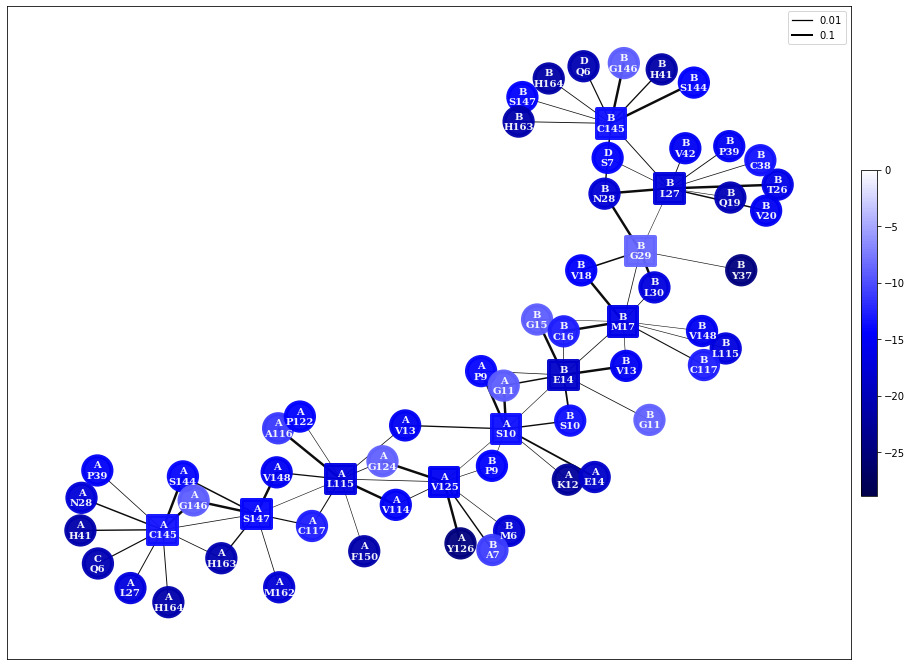

In [26]:
two.display_graph(restrict_to=full_list,bond_orders=bo,field_vals=Diagonal_energy,
                  bo_cutoff=0.005)

In [30]:
def build_dataframe_of_contact_interactions_from_sys(pop,bond_orders,interactions,substrates):
    from BigDFT.Stats import Population,weighted_dataframe
    from BigDFT.Systems import system_from_df
    labels=['contact_bond_orders','contact_interactions','electrostatic_interactions']#,'dispersion_interactions','total_interactions']
    pops={}
    for i,s in enumerate(substrates):
        pops.update({str(i)+'_'+lb: Population(labels=str(i)+'_'+lb) for lb in labels})
    for i,(sys_df,w,l) in enumerate(zip(pop.datas,pop.weights,pop.sample_labels)):
        bsys=BioQM.BioSystem.from_sys(system_from_df(sys_df))
        setattr(bsys,'_pairwise_BO',bond_orders.datas[i])
        setattr(bsys,'_interactions',interactions.datas[i])
        for i,substrate in enumerate(substrates):
            
            bsys.calculate_contact_regions(target=substrate, cutoff_bo=0.001,
                                                         cutoff_el=10)
            bsys.calculate_target_interactions(target=substrate,
                                               include_dispersion=False,#True,
                                               nthreads=4,
                                               name=str(i))        
        print(i)
        for lb in pops:
            pops[lb].append(data=bsys.fragment_values(lb),weight=w,label=l)
    return pops

In [32]:
newdata=build_dataframe_of_contact_interactions_from_sys(two.populations['system_dfs'],
                                                                two.populations['bond_orders'],
                                                                two.populations['interactions'],
                                                                [two.sequences_to_fragments[2],two.sequences_to_fragments[3]])

/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


/opt/bigdft/install/lib/python3.7/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


1


In [53]:
def features_to_display(pop,extra,name):
    from numpy import nan,array
    #dist=pop.fragment_values('substrate_distance')
    #fv=array([d if f not in pop.sequences_to_fragments[2] else nan for f,d in zip(pop.fragment_names,dist['field_vals'])])
    #fcd=pop.colordict(field_vals=fv.clip(0,6),colorcode='pink')
    features={}#'distance-'+name:fcd}
    field_vals={} #{'distance-'+name:{'data':dist,'kwargs':{'alpha':0.5,'kind':'scatter'}}}
    for k,v in extra.items():
        print (k)
        if 'bond_orders' in k:
            continue
        kk='-'.join((k,name))
        features[kk]=pop.colordict(v.mean)
        field_vals[kk]={'data':{'field_vals':v.mean,'errors':v.std},'kwargs':{'alpha':0.5}}
    return {'features':features,'field_vals':field_vals}

In [50]:
newdata['1_contact_bond_orders'].datas[0]

In [44]:
from BigDFT.Interop import DNAviewerInterop as D

In [54]:
D.display_records(D.sys_into_records(two,**features_to_display(two,newdata,'two')))

0_contact_bond_orders
0_contact_interactions
0_electrostatic_interactions
1_contact_bond_orders
1_contact_interactions
1_electrostatic_interactions


KeyError: 'A-GLY:2'

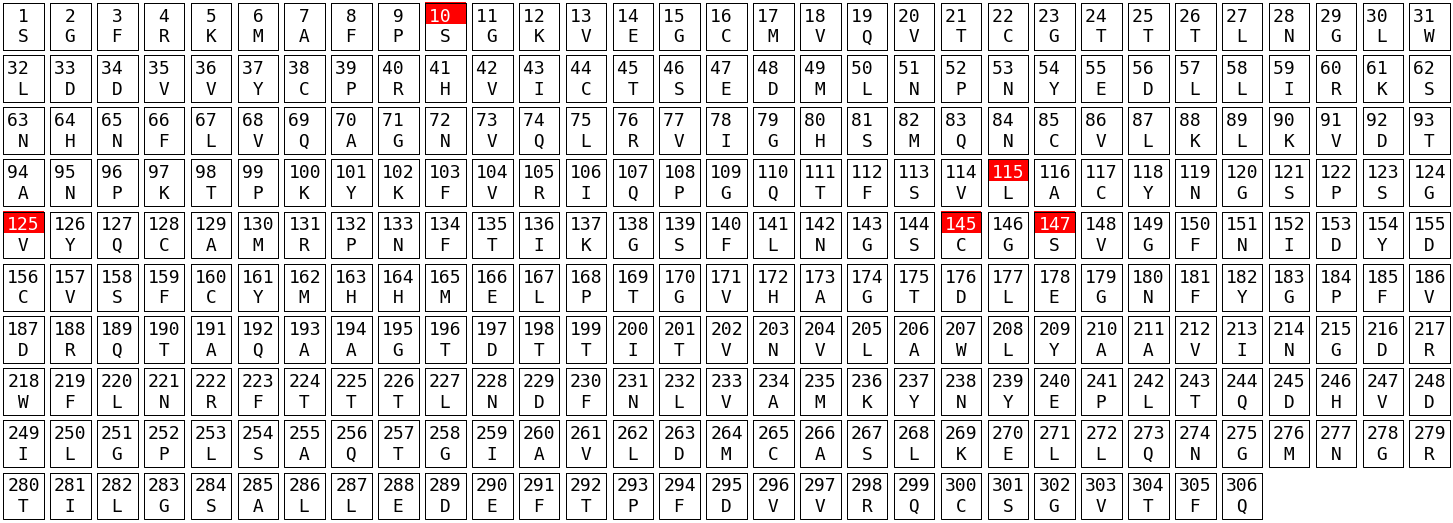

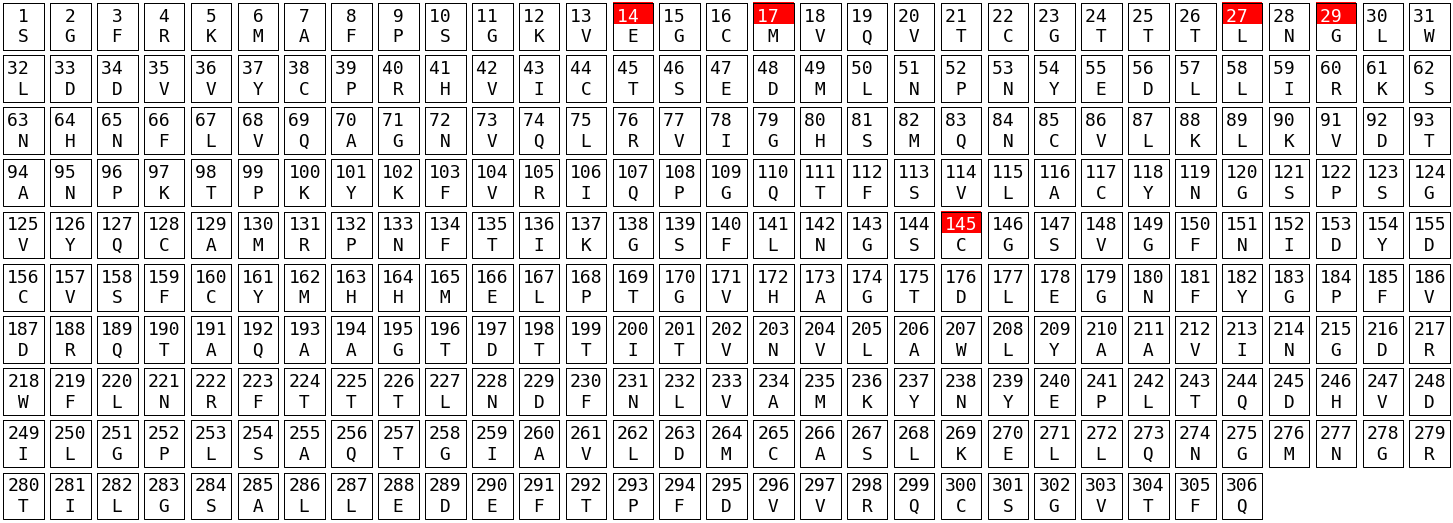

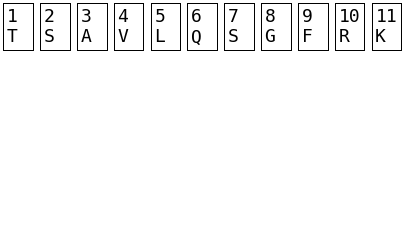

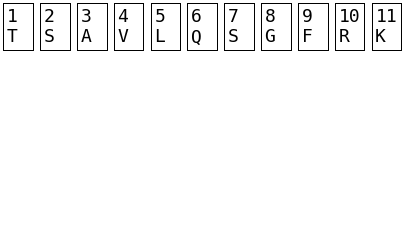

In [178]:
two.dBigDFT.Interopces(highlight=full_list,with_fragment_labels=True)

In [23]:
fi=two.fragment_interaction_strengths(two.sequences_to_fragments[2]+two.sequences_to_fragments[3],criteria='bond_order')

In [35]:
contact = [name for fbo,name in zip(fi,two.fragment_names) if fbo > 0.005 and 'B-' in name]

In [36]:
contact

['B-GLY:23',
 'B-THR:24',
 'B-THR:26',
 'B-HIS:41',
 'B-MET:49',
 'B-ASN:142',
 'B-GLY:143',
 'B-CYS:145',
 'B-HIS:163',
 'B-MET:165',
 'B-GLU:166',
 'B-GLN:189',
 'B-THR:190']

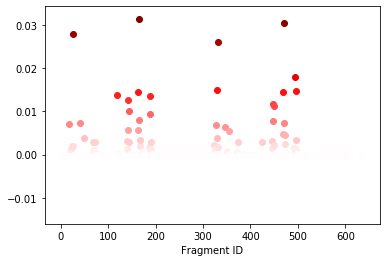

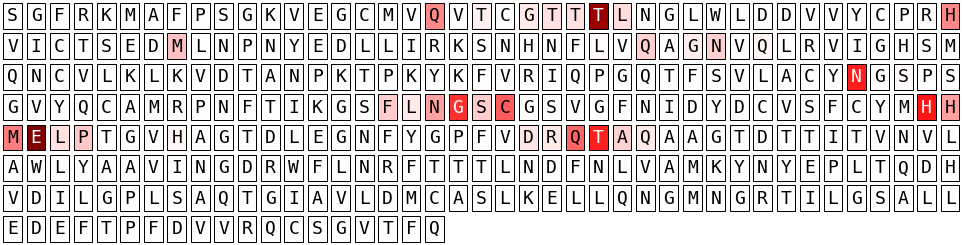

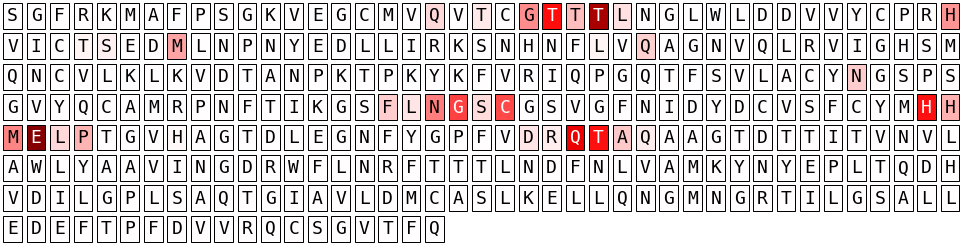

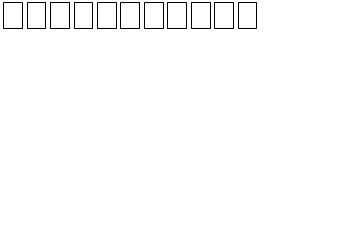

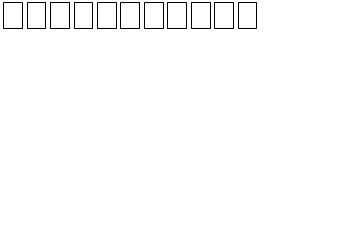

In [24]:
two.represent(field_vals=fi)